# Wage Prediction Example in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns 
%matplotlib inline
from numpy.linalg import inv
import scipy
import scipy.odr as odr

# For linear regression, we will need
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
# Read the data in the link.
df = pd.read_excel("./input_data/Wage.xlsx",
                   sheet_name = 'Wage_Data',
                   header = 1)
df.head()

,Column1,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage,est_education_yrs,est_experience,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154,10,8,75.043154,NaN,NaN,NaN,NaN
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020,16,8,NaN,NaN,NaN,70.476020,NaN
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177,14,31,NaN,NaN,130.982177,NaN,NaN
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293,16,27,NaN,NaN,NaN,154.685293,NaN
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154,12,38,NaN,75.043154,NaN,NaN,NaN


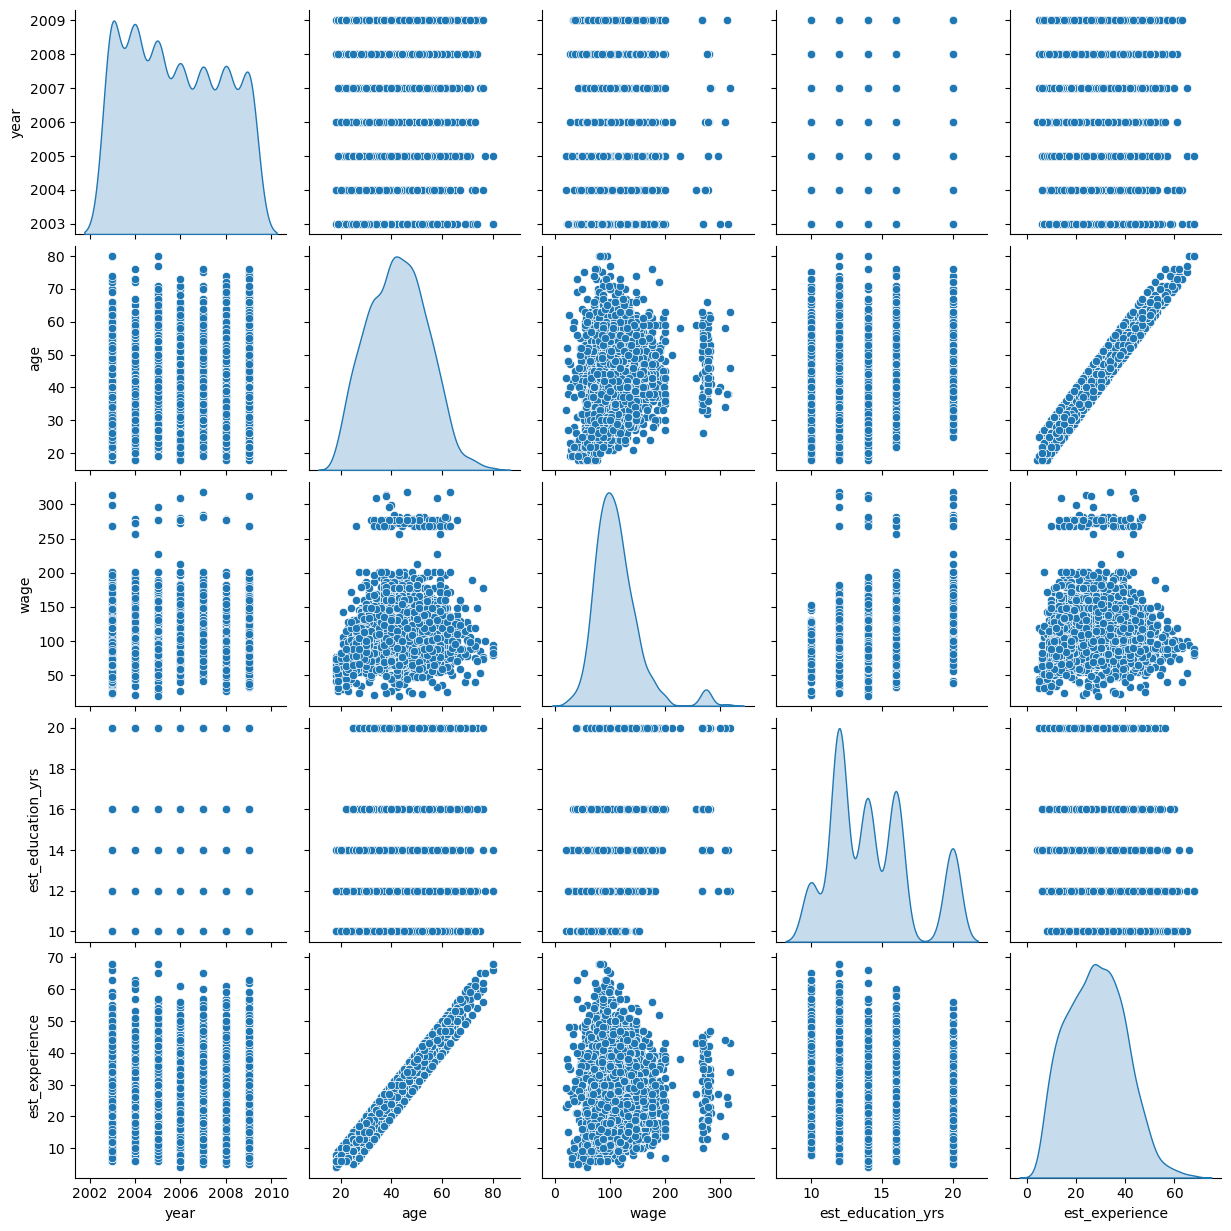

In [3]:
sns.pairplot(df[['year', 'age', 'wage', 'est_education_yrs', 'est_experience']],
            diag_kind = 'kde' # 'hist' or 'kde'
            );

Notes and Observations:
- A few of the histograms show what we want to see. The age and Estimated experience are close to Normal distributions. The wage there seems to be gap but would have preferred something close to a Noarmal distribution as well. A normal distribution would follow typical population distribution.
- Age and estimated experience is linearly related to estimated experience. Note that there were a few assumptions on the estimated experience and the dataset does not seem to consider retirement which would flatten the estimated experience at some point.

CPU times: total: 4.89 s
Wall time: 3.74 s


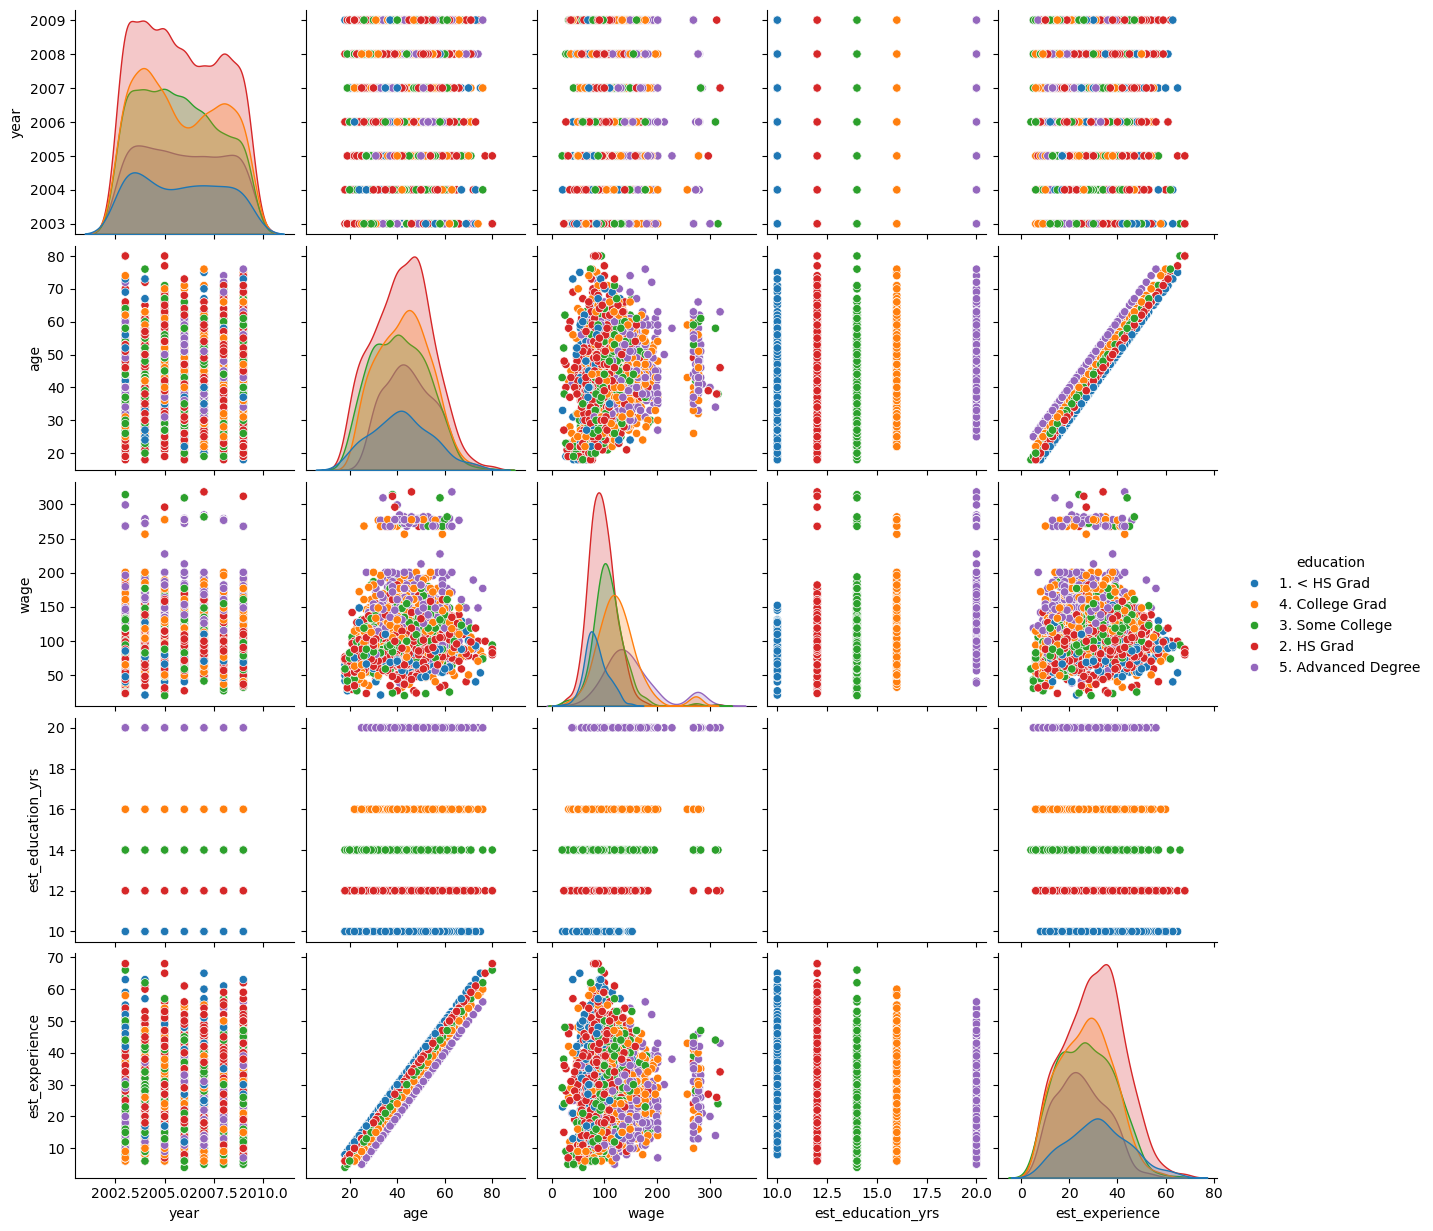

In [4]:
%%time
sns.pairplot(df[['year', 'age', 'wage', 'est_education_yrs', 'est_experience', 'education']],
            diag_kind = 'kde', # 'hist' or 'kde'
            hue = 'education'
            );

Notes and Observations:
- We can now observe the distributions by Education level.
- It is expected that as eductaion increases so would age which can be seen in many of the KDE Plots.
- The plot for Estimated Experience vs. Age seems to show each Education path is linearly related which is expected given the assumptions to calculate the estimated experience. 
- The KDE for Age, Wage, and Estimated Experience seem to follow expected distributions.

# Averages by Education and Estimated Experience

In [5]:
# Average wage by estimated experience.
df_avg_educ = df.groupby(['education', 'est_experience'])['wage'].mean().reset_index()
df_avg_educ.head()

,education,est_experience,wage
0,1. < HS Grad,8,60.206675
1,1. < HS Grad,9,52.990109
2,1. < HS Grad,10,72.479316
3,1. < HS Grad,11,75.043154
4,1. < HS Grad,12,75.043154


CPU times: total: 1.48 s
Wall time: 436 ms


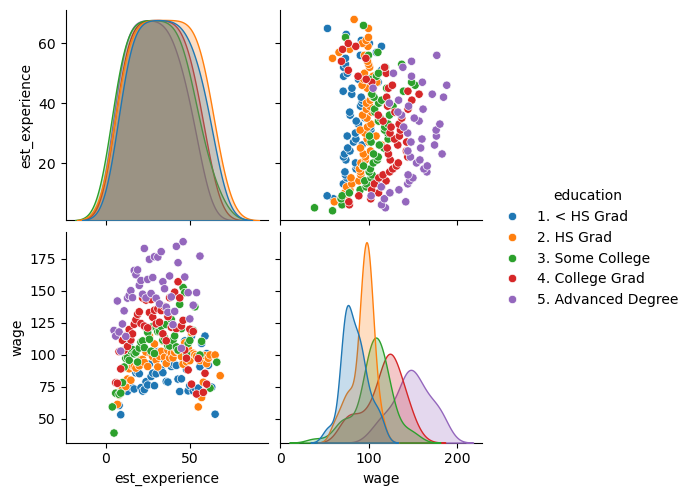

In [6]:
%%time
sns.pairplot(df_avg_educ,
            diag_kind = 'kde', # 'hist' or 'kde'
            hue = 'education'
            );

# Average Wage by Estimated Experience

In [7]:
# Average wage by estimated experience.
df_avg = df.groupby(['est_experience'])['wage'].mean().reset_index()
df_avg.head()

,est_experience,wage
0,4,59.097064
1,5,70.773759
2,6,74.954408
3,7,81.678374
4,8,78.894193


### Linear Regression

y = 105.74 + -0.06x
R2 = 0.0047


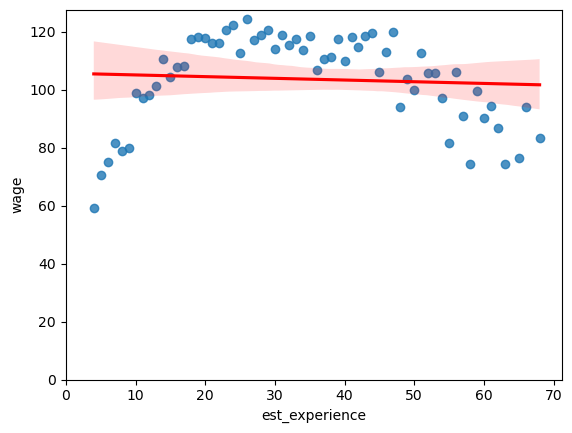

In [8]:
p = sns.regplot(data= df_avg, 
            x="est_experience", y="wage", line_kws=dict(color="r"))
# Adjusts the axis limits to start at 0.
plt.xlim(0) 
plt.ylim(0)

# Calculates the slope and intercept from the SNS regression line using SciPy.
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())
# Calculates r_value on the fitted data.
r_value, p_value = scipy.stats.pearsonr(x = df_avg['est_experience'],
                                        y = df_avg['wage'])
r2_value = r_value**2

# Print 2nd order olynomial equation and r2 value
print('y = ' + str(round(intercept,2)) + ' + ' + str(round(slope,2)) + 'x')
print(f"R2 = {round(r2_value, 4)}")

### Polynomial Order of 2 Regression 

y = -0.05x^2 + 3.312x + 65.305
R2 = 0.69


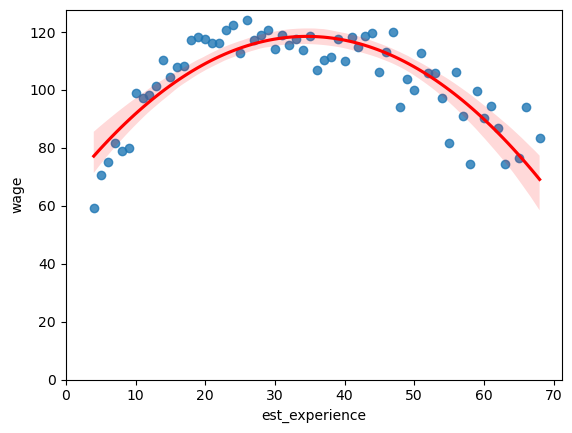

In [9]:
p = sns.regplot(data= df_avg, 
                x="est_experience", y="wage", 
                order = 2, line_kws=dict(color="r"))
# Adjusts the axis limits to start at 0.
plt.xlim(0)
plt.ylim(0)

# Calculates the slope and intercept from the SNS regression line using SciPy.
poly_model = odr.polynomial(2)
data_odf = odr.Data(x = df_avg['est_experience'], y = df_avg['wage'])
odr_obj = odr.ODR(data = data_odf, model = poly_model)
output = odr_obj.run()
coeff = output.beta # Fitted Coefficients

#R2 Value Calculation
def quadratic(coeff, x): # For each X returns the predicted y. 
    return coeff[0] + coeff[1]*x + coeff[2]*x**2

# Calculate predicted values using the fitted coefficients
y_pred = quadratic(coeff, x = df_avg['est_experience'])
# Calculate R-squared
y_mean = np.mean(df_avg['wage'])
SS_tot = np.sum((df_avg['wage'] - y_mean)**2)
SS_res = np.sum((df_avg['wage'] - y_pred)**2)
r_squared = 1 - (SS_res/SS_tot)

# Print 2nd order olynomial equation and r2 value
print(f"y = {round(coeff[2], 3)}x^2 + {round(coeff[1], 3)}x + {round(coeff[0], 3)}")
print(f"R2 = {round(r_squared, 2)}")

Note the difference between MS Excel 2nd order Polynomial regression and ODR 2nd order Polynomial regression which  may be due to differen calculation methods. Also challenging is the fact that each Python library has its own capabilities. While sns.regplot makes it very easy to plot the Order 2 Polynomial Regression it does not provide the equation nor R2 values. This makes us needing to rely on another library for obtaining the coefficient, equation, and R2 value.

# Wage Prediction

In [10]:
def wage_prediction(experience_inyrs, model_type):
    global predicted_wage
    if model_type == "Linear":
        # Remember the Linear regression equation from the data: y = 105.74 + -0.06x
        predicted_wage = 105.74 + -0.06*experience_inyrs
    else: # Else uses the Polynomial order of 2.
        # Remember the polynomial order 2 regression equation from the data: y = -0.05x^2 + 3.312x + 65.305
        predicted_wage = -0.05*(experience_inyrs)**2 + 3.312*(experience_inyrs) + 65.305

In [11]:
experience_inyrs = float(input(prompt = "Estimated experience in years as a float."))
model_type = input(prompt = "Model Type: Linear or Poly?") # For Model change to "Linear" or "Poly"
wage_prediction(experience_inyrs = experience_inyrs, model_type = model_type) 
print(f"Predicted wage for {experience_inyrs} years of experience is: ${int(1000*(predicted_wage))} per year.")

Estimated experience in years as a float. 10
Model Type: Linear or Poly? Poly


Predicted wage for 10.0 years of experience is: $93425 per year.


Notes and Questions:
- From the R2 value, which model was a better fit to the data?
- What happens if we put 150 as estimated experience in years?
- Does the data or model have any limits?

Other notes:
- Recall that this is only predicted for the average wage regardless of the education.
- To take into account educations there may be various approaches we need to create a multi-variable regression model/equation or one model/equation for each education level.

### Wage Prediction Alternative Approach

Instead of defining the equation in the function, this approach utilizes the SKLearn Regression function to do both caclulate and predict both in the same function.

In [81]:
def wage_prediction_alt(experience_inyrs, model_type):
    global predicted_wage, model_eq_names, model_coefficients, model_intercept
    X = df_avg[['est_experience']].to_numpy()
    y = df_avg['wage'].to_numpy()
    
    if model_type == "Linear": 
        model = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())  # LinearRegression Function from SKLearn
        #model = LinearRegression() # LinearRegression Function from SKLearn
    else: 
        model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression()) # PolynomialRegression Function from SKLearn
                
    model.fit(X, y) # Fit model to data.
    predicted_wage = model.predict(np.array([[experience_inyrs]]))

    model_eq_names = model.steps[0][1].get_feature_names_out()
    model_coefficients = model.steps[1][1].coef_
    model_intercept = model.steps[1][1].intercept_

In [83]:
experience_inyrs = float(input(prompt = "Estimated experience in years as a float."))
model_type = input(prompt = "Model Type: Linear or Poly?") # For Model change to "Linear" or "Poly"
wage_prediction_alt(experience_inyrs = experience_inyrs, model_type = model_type) 
print(f"Predicted wage for {experience_inyrs} years of experience is: ${int(1000*(predicted_wage)[0])} per year.")
print(f"Equation Coefficient Names: {model_eq_names}")
print(f"Coefficients:", model_coefficients)
print(f"Intercept: ", model_intercept)

Estimated experience in years as a float. 10
Model Type: Linear or Poly? Poly


Predicted wage for 10.0 years of experience is: $91781 per year.
Equation Coefficient Names: ['1' 'x0' 'x0^2']
Coefficients: [ 0.          3.05754337 -0.04421164]
Intercept:  65.62685321405793


# Wage Prediction with Education Level

When predicting with education level, we need to consider that the education level is represented in two ways. 1. As initially in a categorical form (e.g., <High School, High School, etc.) or numerical in estimated education years. Note that there were various assumptions that went with the estimated education in years. Using each may produce slight differences in how a regression model predicts wages. In any case both need to be converted into a numerical form. Either using the integer of the categorical values such as <High School is 1, High School is 2, etc. or using the numerical values of the estimated education years.

In [125]:
# Average wage by estimated experience and education level.
df_avg = df.groupby(['education', 'est_experience'])['wage'].mean().reset_index()
# Updating the education level to an integer if needed.
#df_avg['education'] = df_avg['education'].str.split('.').str[0].astype(int)
df_avg.sample(3)

,education,est_experience,wage
222,5. Advanced Degree,9,102.717570
136,3. Some College,27,102.663720
221,5. Advanced Degree,8,117.673532


We will use the estimated education years.

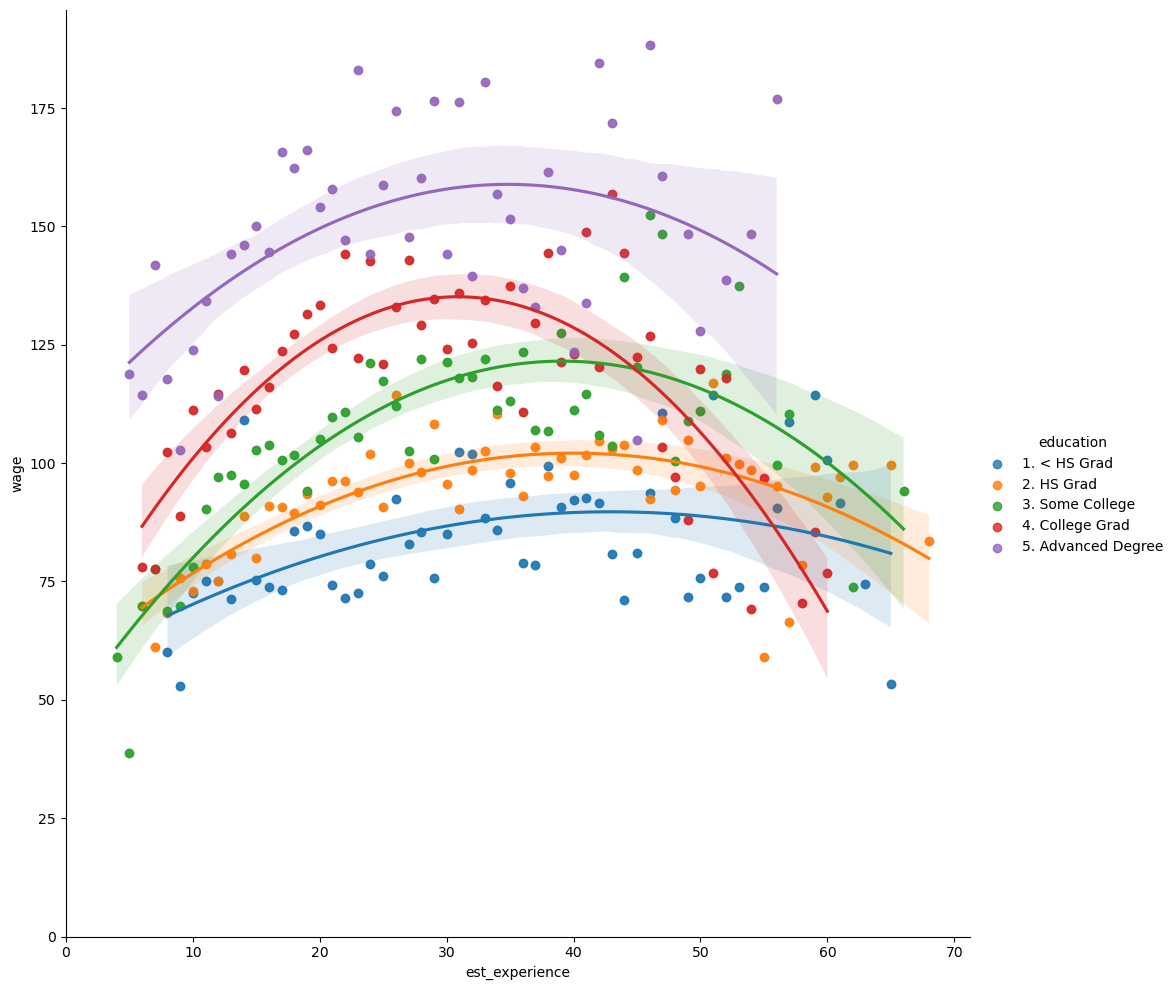

In [126]:
# This plot shows all polynomial order 2 regressiosn for each education level and average wages by years of experience. 
p = sns.FacetGrid(data = df_avg, height = 10, hue = 'education');
p.map(plt.scatter, "est_experience", "wage", s=50, alpha=.7, linewidth=.5, edgecolor="white")
p.map(sns.regplot, "est_experience", "wage", order = 2)
p.add_legend();

# Adjusts the axis limits to start at 0.
plt.xlim(0);
plt.ylim(0);

Notes and Questions:
- Do we expect the R2 value for the different type of regressions to be the same for each education level?
- Which model is expected to be a better fit to the data?
- What happens if we put 150 as estimated experience in years?
- Does the data or model have any limits?

# Wage Prediction
Wage prediction could be performed using multiple approaches.
1. Because the Education is a categorical value, we can develop a polynomial regression for each level of education.
2. The dataset assumed a number of estimated education years for each categorical level. We could use this estimate to create a multiple variable regression. However, due to the assumption on estimated education years per education level it is expected that this approach potentially has a higher level of uncertainty.

### Wage Prediction: Regression Per Education Level using a Widget

In [92]:
# Filter data first on education level then sthe regression as we did prior.
# Calculate R2 value?

In [98]:
# Average wage by estimated experience and education level.
df_avg = df.groupby(['education', 'est_experience'])['wage'].mean().reset_index()
df_avg.sample(3)

,education,est_experience,wage
131,3. Some College,22,110.715680
255,5. Advanced Degree,42,184.597232
165,3. Some College,66,94.072715


In [115]:
def education_wage_prediction(education_filter, new_est_experience):
    df_avg_filtered = df_avg[df_avg['education'] == education_filter].copy()

    p = sns.regplot(data= df_avg_filtered, 
                    x="est_experience", 
                    y="wage", 
                    order = 2, line_kws=dict(color="r"))
    # Adjusts the axis limits to start at 0.
    plt.xlim(0)
    plt.ylim(0)
    plt.title(f"Wage Plot for Education Level of {education_filter}")

    # Calculates the slope and intercept from the SNS regression line using SciPy.
    poly_model = odr.polynomial(2)
    data_odf = odr.Data(x = df_avg_filtered['est_experience'], 
                        y = df_avg_filtered['wage'])
    odr_obj = odr.ODR(data = data_odf, model = poly_model)
    output = odr_obj.run()
    coeff = output.beta # Fitted Coefficients

    #R2 Value Calculation
    def quadratic(coeff, x): # For each X returns the predicted y. 
        return coeff[0] + coeff[1]*x + coeff[2]*x**2

    # Calculate predicted values using the fitted coefficients
    y_pred = quadratic(coeff, x = df_avg_filtered['est_experience'])
    # Calculate R-squared
    y_mean = np.mean(df_avg_filtered['wage'])
    SS_tot = np.sum((df_avg_filtered['wage'] - y_mean)**2)
    SS_res = np.sum((df_avg_filtered['wage'] - y_pred)**2)
    r_squared = 1 - (SS_res/SS_tot)

    # Print 2nd order olynomial equation and r2 value
    print(f"y = {round(coeff[2], 3)}x^2 + {round(coeff[1], 3)}x + {round(coeff[0], 3)}")
    print(f"R2 = {round(r_squared, 2)}")

    # Wage Prediction
    wage_predicted = coeff[2]*(new_est_experience)**2 + coeff[1]*new_est_experience + round(coeff[0])
    print(f"Predicted wage for {experience_inyrs} years of experience is: ${int(1000*(wage_predicted))} per year.")

In [116]:
df_avg['education'].unique()

array(['1. < HS Grad', '2. HS Grad', '3. Some College', '4. College Grad',
       '5. Advanced Degree'], dtype=object)

y = -0.147x^2 + 9.09x + 7.228
R2 = 0.13
Predicted wage for 10.0 years of experience is: $129977 per year.


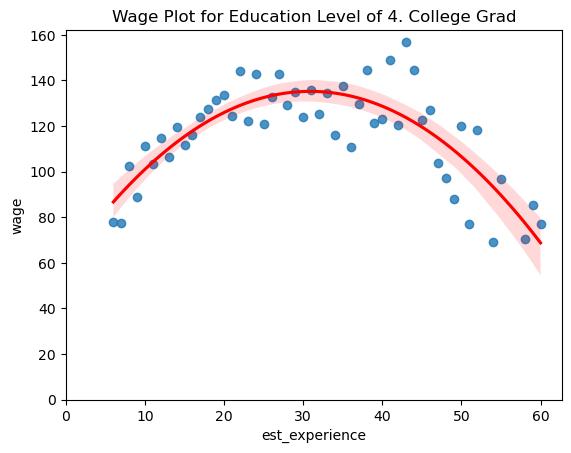

In [118]:
education_wage_prediction(education_filter = df_avg['education'].unique()[3],
                          new_est_experience = 20)
# NEED TO FIX AS NOT PREDICTING and UPDATE TITLES OF EDUCATION BEING USED.

### Wage Prediction: Multiple Variable Regression

In [121]:
# Average wage by estimated experience and education level.
df_avg = df.groupby(['est_education_yrs', 'est_experience'])['wage'].mean().reset_index()
df_avg.sample(3)

,est_education_yrs,est_experience,wage
86,12,38,97.301913
8,10,16,73.775743
206,16,46,126.755464


In [122]:
X = df_avg[['est_education_yrs', 'est_experience']].to_numpy()
y = df_avg['wage'].to_numpy()
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression()) # Create polynomial order of 2 regression model.
model.fit(X, y) # Fit model to data.

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [120]:
# Example prediction
Xnew_education = 10
Xnew_estexperience = 1
y_pred = model.predict(np.array([[Xnew_education, Xnew_estexperience]]))
print(f"Predicted value: {y_pred}")

Predicted value: [34.82324745]


In [89]:
# Multi-Polynomial Regression Equation
print(f"Equation Coefficient Names: {model.steps[0][1].get_feature_names_out()}")
print(f"Coefficients:", model.steps[1][1].coef_)
print(f"Intercept: ", model.steps[1][1].intercept_)

Equation Coefficient Names: ['1' 'x0' 'x1' 'x0^2' 'x0 x1' 'x1^2']
Coefficients: [ 0.          3.35060977  3.82024186  0.15913472 -0.05486834 -0.04159284]
Intercept:  -17.826287783068977


# NOTEBOOK END